# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [67]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [70]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [71]:
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2. Load data

In [2]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [47]:
df.head(3)

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,...,0.085483,0.146033,44.26693,8.145775,44.26693,3,30,5,2,6
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,...,0.085483,0.151367,44.44471,0.000000,44.44471,7,76,7,76,4
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,...,0.089162,0.172468,44.44471,0.000000,44.44471,6,68,3,68,8


In [50]:
df.dtypes

Unnamed: 0            int64
id                   object
channel_sales        object
cons_12m              int64
cons_gas_12m          int64
                      ...  
tenure                int32
months_activ          int32
months_to_end         int32
months_modif_prod     int32
months_renewal        int32
Length: 72, dtype: object

---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [4]:
price_df = pd.read_csv('dataset/price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [20]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff.head()

,id,price_date,dec_1,dec_2,price_off_peak_var,price_off_peak_fix
0,0002203ffbb812588b632b9e628cc38d,2015-12-01,0.119906,40.728885,0.126098,40.565969
1,0004351ebdd665e6ee664792efc4fd13,2015-12-01,0.143943,44.444710,0.148047,44.266931
2,0010bcc39e42b3c2131ed2ce55246e3c,2015-12-01,0.201280,45.944710,0.150837,44.444710
3,0010ee3855fdea87602a5b7aba8e42de,2015-12-01,0.113068,40.728885,0.123086,40.565969
4,00114d74e963e47177db89bc70108537,2015-12-01,0.145440,44.266930,0.149434,44.266931


In [16]:
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [21]:
df = pd.merge(df, diff, on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_3m_price_mid_peak_fix,mean_3m_price_off_peak,mean_3m_price_peak,mean_3m_price_mid_peak,churn,price_date,dec_1,dec_2,price_off_peak_var,price_off_peak_fix
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,8.145777,42.629663,12.311304,8.182687,1,2015-12-01,0.146033,44.266930,0.125976,40.565969
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.000000,44.592310,0.000000,0.000000,0,2015-12-01,0.147600,44.444710,0.151367,44.266931
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.000000,44.612508,0.088409,0.000000,0,2015-12-01,0.167798,44.444710,0.172468,44.266931
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.000000,44.593296,0.000000,0.000000,0,2015-12-01,0.148586,44.444710,0.153133,44.266931
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,16.291555,40.848791,24.539003,16.365274,0,2015-12-01,0.119906,40.728885,0.126098,40.565969


In [22]:
# finding average prices per period by company
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [23]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [24]:
columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,dec_1,dec_2,price_off_peak_var,price_off_peak_fix,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.146033,44.266930,0.125976,40.565969,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.147600,44.444710,0.151367,44.266931,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.167798,44.444710,0.172468,44.266931,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.148586,44.444710,0.153133,44.266931,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,0.119906,40.728885,0.126098,40.565969,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


In [25]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [32]:
mean_prices_by_month.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389,0.022123,0.033743,0.055866,16.226389,8.113192,24.339581
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389,0.022123,0.033743,0.055866,16.226389,8.113192,24.339581
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555,0.022225,0.032069,0.054294,16.291555,8.145775,24.437330
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555,0.022225,0.032069,0.054294,16.291555,8.145775,24.437330
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555,0.022225,0.032069,0.054294,16.291555,8.145775,24.437330


In [27]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [28]:
# getting the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

max_diff_across_periods_months

,id,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,0002203ffbb812588b632b9e628cc38d,0.022225,0.033743,0.055866,16.291555,8.145775,24.437330
1,0004351ebdd665e6ee664792efc4fd13,0.148405,0.000000,0.148405,44.444710,0.000000,44.444710
2,0010bcc39e42b3c2131ed2ce55246e3c,0.205742,0.000000,0.205742,45.944710,0.000000,45.944710
3,0010ee3855fdea87602a5b7aba8e42de,0.022581,0.031859,0.054440,16.291555,8.145775,24.437330
4,00114d74e963e47177db89bc70108537,0.149902,0.000000,0.149902,44.266931,0.000000,44.266931
...,...,...,...,...,...,...,...
16091,ffef185810e44254c3a4c6395e6b4d8a,0.029128,0.042028,0.071156,16.291555,8.145775,24.437330
16092,fffac626da707b1b5ab11e8431a4d0a2,0.148825,0.000000,0.148825,44.444710,0.000000,44.444710
16093,fffc0cacd305dd51f316424bbb08d1bd,0.028520,0.039592,0.068112,16.291555,8.145775,24.437330
16094,fffe4f5646aa39c7f97f95ae2679ce64,0.022138,0.031941,0.054079,16.291555,8.145775,24.437330


In [29]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


***Tenure***

How long a company has been a client of PowerCo

In [35]:
df["tenure"] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'Y')).astype(int)
df["tenure"]

0        3
1        7
2        6
3        6
4        6
        ..
14600    3
14601    4
14602    3
14603    4
14604    6
Name: tenure, Length: 14605, dtype: int32

In [34]:
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

,churn
tenure,
3,0.143836
2,0.133080
4,0.125756
13,0.095238
5,0.085425
12,0.083333
6,0.080713
7,0.073394
11,0.063584


companies who have been only client for four years or less then four years are much more likely to churn compared to other client

***Transforming Dates into months***

In [40]:
def convert_months(reference_date, df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [43]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

KeyError: 'date_activ'

In [44]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)

KeyError: "['date_activ' 'date_end' 'date_modif_prod' 'date_renewal'] not found in axis"

In [45]:
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,...,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,...,0.085483,0.146033,44.266930,8.145775,44.26693,3,30,5,2,6
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,...,0.085483,0.151367,44.444710,0.000000,44.44471,7,76,7,76,4
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,...,0.089162,0.172468,44.444710,0.000000,44.44471,6,68,3,68,8
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,...,0.000000,0.153133,44.444710,0.000000,44.44471,6,69,2,69,9
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,...,0.033743,0.055866,16.291555,8.145775,24.43733,6,71,2,71,9


***Transforming boolean data***

has_gas we simply want to transform this column from being categorical to being a binary flag

In [46]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})

,churn
has_gas,
0,0.100544
1,0.081887


customer who buy multiple products from company are show client are loyal towards company. churn % are low

***Transforming categorical data***

In [56]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')

# Let's see how many categories are within this column
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

In [57]:
df['channel_sales']

0        foosdfpfkusacimwkcsosbicdxkicaua
1                                 MISSING
2        foosdfpfkusacimwkcsosbicdxkicaua
3        lmkebamcaaclubfxadlmueccxoimlema
4                                 MISSING
                       ...               
14600    foosdfpfkusacimwkcsosbicdxkicaua
14601    foosdfpfkusacimwkcsosbicdxkicaua
14602    foosdfpfkusacimwkcsosbicdxkicaua
14603    foosdfpfkusacimwkcsosbicdxkicaua
14604                             MISSING
Name: channel_sales, Length: 14605, dtype: category
Categories (8, object): ['MISSING', 'epumfxlbckeskwekxbiuasklxalciiuu', 'ewpakwlliwisiwduibdlfmalxowmwpci', 'fixdbufsefwooaasfcxdxadsiekoceaa', 'foosdfpfkusacimwkcsosbicdxkicaua', 'lmkebamcaaclubfxadlmueccxoimlema', 'sddiedcslfslkckwlfkdpoeeailfpeds', 'usilxuppasemubllopkaafesmlibmsdf']

In [59]:
#One hot encoding using get_dummies()
df = pd.get_dummies(df, columns = ['channel_sales'], prefix='channel')

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_epumfxlbckeskwekxbiuasklxalciiuu,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_fixdbufsefwooaasfcxdxadsiekoceaa,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_sddiedcslfslkckwlfkdpoeeailfpeds,channel_usilxuppasemubllopkaafesmlibmsdf
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,...,2,6,0,0,0,0,1,0,0,0
1,1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,...,76,4,1,0,0,0,0,0,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,...,68,8,0,0,0,0,1,0,0,0
3,3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,...,69,9,0,0,0,0,0,1,0,0
4,4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,...,71,9,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14600,14600,18463073fb097fc0ac5d3e040f356987,32270,47940,0,4648.01,0,0.0,18.57,0.138305,...,7,19,0,0,0,0,1,0,0,0
14601,14601,d0a6f71671571ed83b2645d23af6de00,7223,0,181,631.69,181,0.0,144.03,0.100167,...,40,4,0,0,0,0,1,0,0,0
14602,14602,10e6828ddd62cbcf687cb74928c4c2d2,1844,0,179,190.39,179,0.0,129.60,0.116900,...,46,10,0,0,0,0,1,0,0,0
14603,14603,1cf20fd6206d7678d5bcafd28c53b4db,131,0,0,19.34,0,0.0,7.18,0.145711,...,40,4,0,0,0,0,1,0,0,0


In [60]:
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,...,3,30,5,2,6,0,0,1,0,0
1,1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,...,7,76,7,76,4,1,0,0,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,...,6,68,3,68,8,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,...,6,69,2,69,9,0,0,0,1,0
4,4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,...,6,71,2,71,9,1,0,0,0,0


In [61]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [62]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,Unnamed: 0,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,...,2,6,0,0,1,0,0,0,0,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,...,76,4,1,0,0,0,0,1,0,0
2,2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,...,68,8,0,0,1,0,0,1,0,0
3,3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,...,69,9,0,0,0,1,0,1,0,0
4,4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,...,71,9,1,0,0,0,0,1,0,0


In [63]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460500e+04,1.460500e+04,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,1.592303e+05,2.809108e+04,16091.371448,1868.638618,1399.858747,0.966450,63.090448,0.137282,0.050488,43.130085
std,5.734836e+05,1.629786e+05,64366.262314,2387.651549,3247.876793,5.108355,66.166636,0.024623,0.049037,4.486140
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674000e+03,0.000000e+00,0.000000,494.980000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411600e+04,0.000000e+00,793.000000,1112.610000,314.000000,0.000000,18.800000,0.143166,0.084138,44.311378
75%,4.076400e+04,0.000000e+00,3383.000000,2402.270000,1746.000000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


In [64]:
#Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [65]:
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,4.223945,0.778978,2.264801,2.962162,1.784733,0.966450,1.517233,0.137282,0.050488,43.130085
std,0.884545,1.716828,1.769266,0.683612,1.584972,5.108355,0.571489,0.024623,0.049037,4.486140
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.753966,0.000000,0.000000,2.695464,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149742,0.000000,2.899821,3.046733,2.498311,0.000000,1.296665,0.143166,0.084138,44.311378
75%,4.610287,0.000000,3.529430,3.380803,3.242293,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


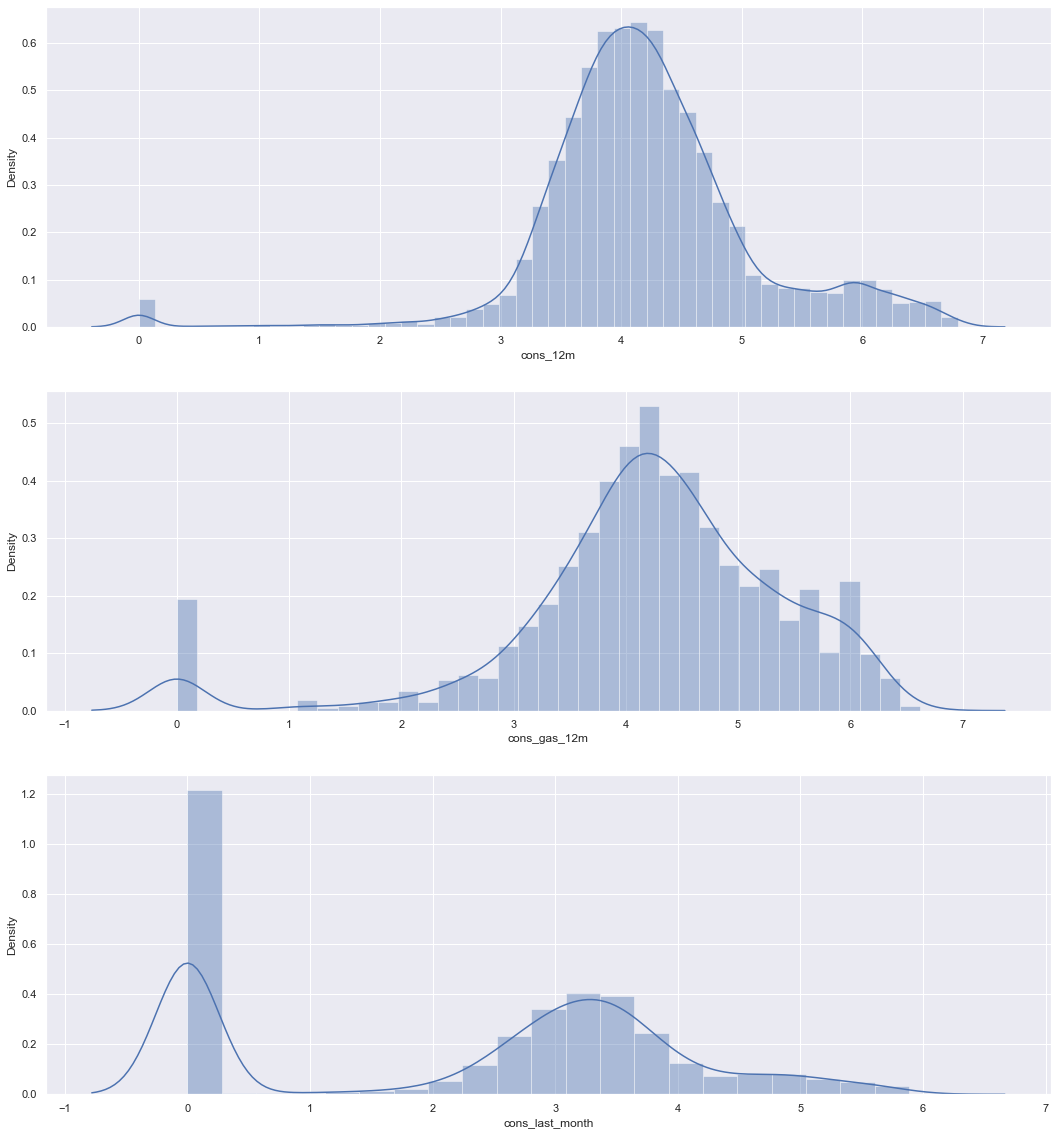

In [72]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()